## About the Project

* Vesta Corporation provided the dataset for this competition. Vesta Corporation is the forerunner in guaranteed e-commerce payment solutions. Founded in 1995.
 
* In this competition, the aim is to benchmark machine learning models on a challenging large-scale dataset. 
* The data comes from Vesta's real-world e-commerce transactions and contains a wide range of features from device type to product features. 
* The machine learning model will alert the fraudulent transaction for millions of people around the world, helping hundreds of thousands of businesses reduce their fraud loss and increase their revenue. 
* The training dataset consists of more than 400 features and 5.9 Million samples. This is supervised binary classification problem and goal is to predict if a credit card transaction is Fraud based on input features mentioned below

**Evaluation**
* The model is evaluated on AUC ROC score. The notebook will produce an output csv file with TransactionID and predicted probabilties on test set,  which will be automatically evaluted by Kaggle.

### Transaction Table 
* TransactionDT: timedelta from a given reference datetime (not an actual timestamp)
* TransactionAMT: transaction payment amount in USD
* ProductCD: product code, the product for each transaction
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* addr: address
* dist: distance
* P_ and (R__) emaildomain: purchaser and recipient email domain
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* D1-D15: timedelta, such as days between previous transaction, etc.
* M1-M9: match, such as names on card and address, etc.
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.

<br>  **Categorical Features:**
* ProductCD
* card1 - card6
* addr1, addr2
* P_emaildomain
* R_emaildomain
* M1 - M9

### Identity Table 
* Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
* They're collected by Vesta’s fraud protection system and digital security partners.
* (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

<br> **Categorical Features:**
* DeviceType
* DeviceInfo
* id_12 - id_38



## Import Libraries

In [1]:
#Install latest version of the package as  the defualt version is not working fine
!pip install seaborn==0.11.0

     |████████████████████████████████| 283 kB 192 kB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

hypertools 0.6.2 requires scikit-learn<0.22,>=0.19.1, but you'll have scikit-learn 0.23.2 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os, gc
print(os.listdir("../input"))

import seaborn as sns
sns.set_theme(style="darkgrid")

import matplotlib.pyplot as plt

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

#setting for plot fonts 
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


['ieee-fraud-detection']
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv


## Constants

In [3]:
RANDOM_STATE = 42
DEBUG_MODE = False  # Load fewer samples to save time for quick testing
TARGET = 'isFraud'


## Read Data
https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-586800



In [4]:
%%time

# Load fewer samples to save time for quick testing
if DEBUG_MODE:
    nrows = 50000
else:
    nrows = None
        
data_path = '/kaggle/input/ieee-fraud-detection/'
train_identity = pd.read_csv(os.path.join(data_path, 'train_identity.csv'))
train_transaction = pd.read_csv(os.path.join(data_path, 'train_transaction.csv'), nrows = nrows)
test_identity = pd.read_csv(os.path.join(data_path, 'test_identity.csv'))
test_transaction =pd.read_csv(os.path.join(data_path, 'test_transaction.csv'), nrows = nrows)
print('Train Identity Data - rows:', train_identity.shape[0], 
      'columns:', train_identity.shape[1])
print('Train Transaction Data - rows:', train_transaction.shape[0], 
      'columns:', train_transaction.shape[1])
print('Test Identity Data - rows:', test_identity.shape[0], 
      'columns:', test_identity.shape[1])
print('Test Transaction Data - rows:', test_transaction.shape[0], 
      'columns:', test_transaction.shape[1])

Train Identity Data - rows: 144233 columns: 41
Train Transaction Data - rows: 590540 columns: 394
Test Identity Data - rows: 141907 columns: 41
Test Transaction Data - rows: 506691 columns: 393
CPU times: user 53.6 s, sys: 6.14 s, total: 59.8 s
Wall time: 1min 3s


### Transaction Data



In [5]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,...,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,315.0,T,T,T,M0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,111.0,NaN,NaN,NaN,M0,...,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:

def column_properties(df):
    columns_prop = pd.DataFrame()
    columns_prop['column'] = df.columns.tolist()
    columns_prop['count_non_null'] = df.count().values
    columns_prop['count_null'] = df.isnull().sum().values
    columns_prop['perc_null'] = columns_prop['count_null'] * 100 / df.shape[0]

    #using df.nunique() is memory intensive and slow resulting in kernal death
    unique_list = []
    for col in df.columns.tolist():
        unique_list.append(df[col].value_counts().shape[0])
    columns_prop['count_unique'] =  unique_list
    
    columns_prop['dtype'] = df.dtypes.values
    columns_prop.set_index('column', inplace = True)
    return columns_prop


In [7]:
column_properties(train_transaction).T

column,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,...,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
count_non_null,590540,590540,590540,590540,590540,590540,581607,588975,588963,586281,588969,524834,524834,238269,37627,496084,137291,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,590540,589271,309743,327662,421618,280699,73187,38917,74926,74926,514518,311253,64717,61952,62187,501427,319440,319440,319440,309096,...,590528,590528,590528,590528,590528,590528,589271,590528,590528,590528,589271,589271,590528,590528,590528,590528,590528,590528,590528,590528,590528,590528,590528,589271,589271,589271,590528,590528,590528,590528,590528,590528,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351,82351
count_null,0,0,0,0,0,0,8933,1565,1577,4259,1571,65706,65706,352271,552913,94456,453249,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1269,280797,262878,168922,309841,517353,551623,515614,515614,76022,279287,525823,528588,528353,89113,271100,271100,271100,281444,...,12,12,12,12,12,12,1269,12,12,12,1269,1269,12,12,12,12,12,12,12,12,12,12,12,1269,1269,1269,12,12,12,12,12,12,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189,508189
perc_null,0,0,0,0,0,0,1.51268,0.265012,0.267044,0.721204,0.266028,11.1264,11.1264,59.6524,93.6284,15.9949,76.7516,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.214888,47.5492,44.5149,28.6047,52.4674,87.6068,93.4099,87.3123,87.3123,12.8733,47.2935,89.041,89.5093,89.4695,15.0901,45.9071,45.9071,45.9071,47.6588,...,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.214888,0.00203204,0.00203204,0.00203204,0.214888,0.214888,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.214888,0.214888,0.214888,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,0.00203204,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055,86.055
count_unique,590540,2,573349,20902,5,13553,500,114,4,119,4,332,74,2651,1751,59,60,1657,1216,27,1260,319,1328,1103,1253,205,1231,1476,1199,1597,1108,641,641,649,808,688,829,597,12353,24,818,676,635,577,802,859,2,2,2,3,...,58,219,173,870,1286,928,94,13,94,50,12,14,17,21,17,2,16210,37367,23064,4236,19136,3098,8068,5529,11377,6973,9814,15184,12309,4799,6439,5560,881,1411,976,13,45,19,16,100,56,1758,2453,1971,143,672,356,254,380,334
dtype,int64,int64,int64,float64,object,int64,float64,float64,object,float64,object,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


### Identity Data
* Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
* As we can see that the columns name for training set and test are not same,we will correct columns names of test set using traning column name

In [8]:
# the columns name for training set and test are not same,we will correct columns names of test set using traning column name
identity_col_names =  train_identity.columns.tolist()
test_identity.columns = identity_col_names
print(test_identity.columns.tolist())

['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


In [9]:
test_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663586,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [10]:
column_properties(train_identity).T

column,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
count_non_null,144233,144233,140872,66324,66324,136865,136865,5155,5155,74926,74926,140978,144233,127320,80044,140985,129340,139369,45113,139318,139261,5159,5169,5169,4747,5132,5163,5169,140978,140978,77565,140282,77586,73289,77805,140985,140985,140985,140985,140810,118666
count_null,0,0,3361,77909,77909,7368,7368,139078,139078,69307,69307,3255,0,16913,64189,3248,14893,4864,99120,4915,4972,139074,139064,139064,139486,139101,139070,139064,3255,3255,66668,3951,66647,70944,66428,3248,3248,3248,3248,3423,25567
perc_null,0,0,2.33026,54.0161,54.0161,5.1084,5.1084,96.4259,96.4259,48.0521,48.0521,2.25677,0,11.7262,44.5037,2.25191,10.3257,3.37232,68.7221,3.40768,3.4472,96.4231,96.4162,96.4162,96.7088,96.4419,96.4204,96.4162,2.25677,2.25677,46.2224,2.73932,46.2079,49.1871,46.056,2.25191,2.25191,2.25191,2.25191,2.37324,17.7262
count_unique,144233,77,115655,24,15,93,101,84,94,46,62,365,2,54,25,3,2,104,18,522,394,490,25,3,12,341,95,2,2,2,75,130,4,260,4,2,2,2,2,2,1786
dtype,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,object,object,object,object,object,float64,object,object,object,object,object,object,object,object


## Merge Data
Make a join between transaction data and identity data which are connected by key 'TransactionID

In [11]:
%%time
train = pd.merge(train_transaction, train_identity, on= 'TransactionID', how = 'left')
test = pd.merge(test_transaction, test_identity, on= 'TransactionID', how = 'left')
del train_transaction, train_identity, test_transaction, test_identity
gc.collect()
train.shape

CPU times: user 9.53 s, sys: 5.66 s, total: 15.2 s
Wall time: 15.3 s


(590540, 434)

## Categorical Columns
Create list of categorical columns based on decsription below
<br>https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-586800

In [12]:




cat_cols = ['DeviceType', 'DeviceInfo', 'ProductCD', 'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain']
cat_cols +=  ['M' + str(i) for i in range(1,10)]
cat_cols += ['card' + str(i) for i in range(1,7)]
cat_cols += ['id_' + str(i) for i in range(12,39)]
column_properties(train[cat_cols]).T


column,DeviceType,DeviceInfo,ProductCD,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,card1,card2,card3,card4,card5,card6,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count_non_null,140810,118666,590540,524834,524834,496084,137291,319440,319440,319440,309096,240058,421180,244275,244288,244288,590540,581607,588975,588963,586281,588969,144233,127320,80044,140985,129340,139369,45113,139318,139261,5159,5169,5169,4747,5132,5163,5169,140978,140978,77565,140282,77586,73289,77805,140985,140985,140985,140985
count_null,449730,471874,0,65706,65706,94456,453249,271100,271100,271100,281444,350482,169360,346265,346252,346252,0,8933,1565,1577,4259,1571,446307,463220,510496,449555,461200,451171,545427,451222,451279,585381,585371,585371,585793,585408,585377,585371,449562,449562,512975,450258,512954,517251,512735,449555,449555,449555,449555
perc_null,76.1557,79.9055,0,11.1264,11.1264,15.9949,76.7516,45.9071,45.9071,45.9071,47.6588,59.3494,28.6788,58.6353,58.6331,58.6331,0,1.51268,0.265012,0.267044,0.721204,0.266028,75.5761,78.4401,86.4456,76.1261,78.098,76.3997,92.3607,76.4084,76.418,99.1264,99.1247,99.1247,99.1962,99.131,99.1257,99.1247,76.1273,76.1273,86.8654,76.2451,86.8619,87.5895,86.8248,76.1261,76.1261,76.1261,76.1261
count_unique,2,1786,5,332,74,59,60,2,2,2,3,2,2,2,2,2,13553,500,114,4,119,4,2,54,25,3,2,104,18,522,394,490,25,3,12,341,95,2,2,2,75,130,4,260,4,2,2,2,2
dtype,object,object,object,float64,float64,object,object,object,object,object,object,object,object,object,object,object,int64,float64,float64,object,float64,object,object,float64,float64,object,object,float64,float64,float64,float64,float64,float64,object,float64,float64,float64,object,object,object,object,object,float64,object,object,object,object,object,object


In [13]:
train[cat_cols].head()

,DeviceType,DeviceInfo,ProductCD,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,card1,card2,card3,card4,card5,card6,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
0,NaN,NaN,W,315.0,87.0,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,13926,NaN,150.0,discover,142.0,credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,W,325.0,87.0,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,2755,404.0,150.0,mastercard,102.0,credit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,W,330.0,87.0,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,4663,490.0,150.0,visa,166.0,debit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,W,476.0,87.0,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,18132,567.0,150.0,mastercard,117.0,debit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mobile,SAMSUNG SM-G892A Build/NRD90M,H,420.0,87.0,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4497,514.0,150.0,mastercard,102.0,credit,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T


## Numeric Columns
* From list of all columns remove categorical columns, Target Value, and ID, this will give us numerical columns
* Display the statistical properties of numeric columns

In [14]:
%%time


all_cols = train.columns.tolist()
num_cols = [x for x in all_cols if x not in cat_cols]

num_cols.remove('TransactionID')
num_cols.remove(TARGET)
train[num_cols].describe()

CPU times: user 8.04 s, sys: 767 ms, total: 8.81 s
Wall time: 8.84 s


,TransactionDT,TransactionAmt,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,...,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11
count,5.905400e+05,590540.000000,238269.000000,37627.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,589271.000000,309743.000000,327662.000000,421618.000000,280699.000000,73187.000000,38917.000000,74926.000000,74926.000000,514518.000000,311253.000000,64717.000000,61952.000000,62187.000000,501427.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,311253.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,514467.000000,...,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,589271.000000,589271.000000,589271.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,590528.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.000000,82351.00000,82351.000000,82351.000000,82351.000000,82351.000000,144233.000000,140872.000000,66324.000000,66324.000000,136865.000000,136865.000000,5155.000000,5155.000000,74926.000000,74926.000000,140978.000000
mean,7.372311e+06,135.027176,118.502180,231.855423,14.092458,15.269734,0.005644,4.092185,5.571526,9.071082,2.848478,5.144574,4.480240,5.240343,10.241521,4.076227,32.539918,8.295215,94.347568,169.563231,28.343348,140.002441,42.335965,69.805717,41.638950,146.058108,0.561057,123.982137,146.621465,54.037533,17.901295,57.724444,163.744579,0.999945,1.045204,1.078075,0.846456,0.876991,1.045686,1.072870,1.027704,1.041529,0.463915,0.478987,0.559711,0.599166,0.999500,0.122342,0.123460,0.134040,...,0.052002,0.251761,0.283140,0.264208,1.000007,139.748713,408.682375,230.413180,10.995986,118.195658,4.202175,39.173910,21.351473,43.319174,26.806977,109.818544,247.606741,162.153398,18.372476,42.073133,28.326584,6.220289,13.103775,9.184612,0.058494,0.851040,0.296633,0.336790,1.312844,0.775874,721.741883,1375.783644,1014.622782,9.807015,59.16455,28.530903,55.352422,151.160542,100.700882,-10.170502,174716.584708,0.060189,-0.058938,1.615585,-6.698710,13.285354,-38.600388,0.091023,-0.301124,99.745325
std,4.617224e+06,239.162522,371.872026,529.053494,133.569018,154.668899,0.150536,68.848459,25.786976,71.508467,61.727304,95.378574,16.674897,95.581443,94.336292,86.666218,129.364844,49.544262,157.660387,177.315865,62.384721,191.096774,89.000144,143.669253,99.743264,231.663840,0.316880,182.615225,186.042622,124.274558,67.614425,136.312450,202.726660,0.007390,0.240133,0.320890,0.440053,0.475902,0.239385,0.304779,0.186069,0.226339,0.521522,0.552431,0.510533,0.532185,0.022345,0.332422,0.342841,0.364456,...,0.318310,0.481889,0.623608,0.528238,0.002603,2348.849634,4391.992977,3021.924247,116.254277,352.983093,102.374938,172.128339,95.902970,173.619028,116.853222,2270.033202,3980.042828,2793.343636,332.304848,473.499307,382.053171,56.022561,106.739813,73.627893,0.304415,3.950295,1.364356,1.580144,8.769083,4.727971,6217.223583,11169.275702,7955.735482,243.861391,387.62948,274.576920,668.486833,1095.034387,814.946722,14.347949,159651.816856,0.598231,0.701015,5.249856,16.491104,11.384207,26.084899,0.983842,2.789446,1.127602
min,8.640000e+04,0.251000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00

## Feature Engineering
Create new feature and do Analysis for them. 


In [15]:
def plot_numeric_data(df, col, target_col, remove_outliers = False):
   
    df = df[[col, target_col]].copy()
    df.dropna(subset=[col], inplace =True)
    
    #Remove Outliers: keep only the ones that are within +3 to -3 standard deviations in the column 
    if remove_outliers:       
       
        df = df[np.abs(df[col]-df[col].mean()) <= (3*df[col].std())]
       


    fig, (ax1, ax2,ax3)  =  plt.subplots(ncols = 3, figsize = (24,4))
    fig.suptitle('Plots for {}'.format(col))
    
    #Display Density Plot
    sns.distplot(df[col], color = 'b',  kde = True ,  ax = ax1 )
    plt.ylabel('Density')


    # Display Box Plot for feature
    sns.boxplot(x = col , data = df,ax = ax2)
   
    #Display Density Plot for Fraud Vs NotFraud
    sns.distplot(df[df[target_col] == 0][col], color = 'b', label = 'NotFraud',ax = ax3)
    sns.distplot(df[df[target_col] == 1][col], color = 'r', label = 'Fraud',ax = ax3)
    plt.legend(loc = 'best')
    plt.ylabel('Density NotFraud vs Fraud')

    plt.show()
    



In [16]:
def plot_categorical_data(col, data, top_n = 10, display_data = False ):
    
    # Prpare a dataframe for count and postive classs percent givel colums
    df_data = data[[col, TARGET]].copy()    
    df = df_data.groupby(col).agg({col:['count'], TARGET:['sum']})
    df.columns = ['count', 'fraud_count']

    df['fraud_perc'] = df['fraud_count'] * 100 / df['count']
    df['fraude_perc'] = df['fraud_perc'].round(2)
    
#    % missing values in the columns to be displayed in title
    null_perc = (df_data.shape[0]- df['count'].sum())  / df_data.shape[0]

    width = 18
    height = 6

#   select only top n categories
    df_disp = df.sort_values(by ='count', ascending= False).head(top_n )

    fig, (ax1, ax2)  =  plt.subplots(ncols = 2, figsize = (width,height))
    fig.suptitle('Plots for {} (Missing Values: {:.2%})'.format(col, null_perc))
    
#   Display Sort order should be by descending value of count
    plot_order = df_disp.sort_values(by='count', ascending=False).index.values

#   Display Bar chart for frequency count of top_n categories
    s = sns.barplot(ax = ax1,  y = df_disp.index, x = df_disp['count'], order=plot_order, orient = 'h'  )
    s.set_title('Count for {}'.format(col))
    
#   Display Bar chart for perecnt of positive class for top categories
    s = sns.barplot(ax = ax2,  y = df_disp.index, x = df_disp['fraud_perc'], order=plot_order , orient = 'h'    )
    s.set(xlabel='Fraud Percent')
    s.set_title('% Fraud {}'.format(col))
    plt.show()
    if display_data:
        return df

### New Feature: Number of Nulls
* Count the number of null values in a row. As we can see this is an important feature .
* This is because as evident from from joint distribution plot if a trasactions have fewer data points availible(more nulls), the chances of fraud are low

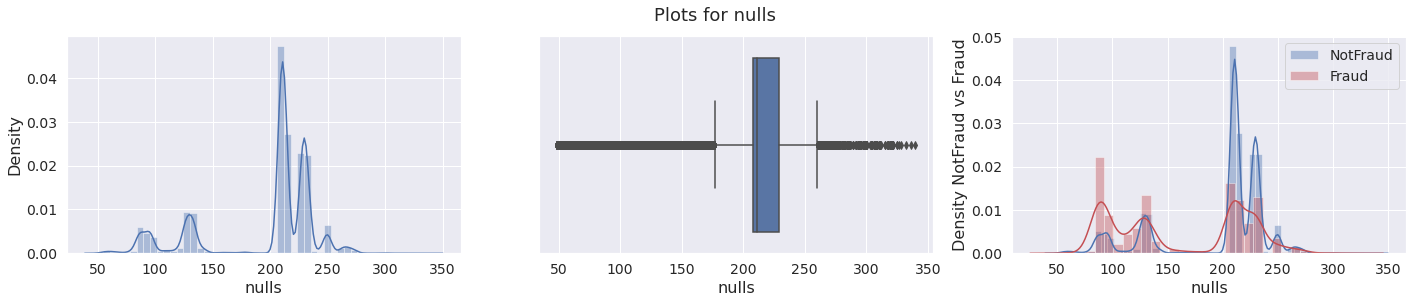

In [17]:
display_features = ['TransactionID']


col = 'nulls'
train[col] = train.isnull().sum(axis=1)
test[col] = test.isnull().sum(axis=1)

display_features.append(col)
plot_numeric_data(train, col, TARGET, remove_outliers = True)

### New Feature:Transaction Amount Decimal part
* Get the decimal part of Transaction Amount and Multiply it by 1000
* This is probably due to fraud transaction happening in foreign currency hence the credit card is charged with decimal amount.
* We can also see that if the decimal part of transaction amount is zero chances of fraud are less


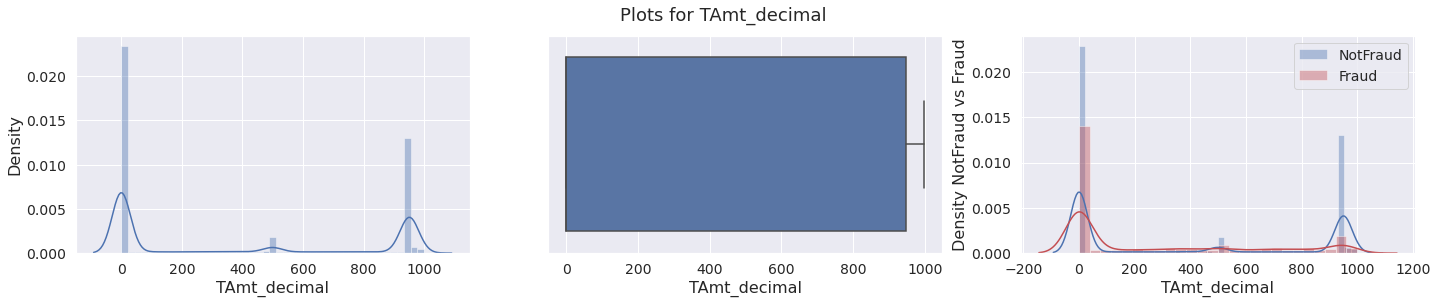

In [18]:

col = 'TAmt_decimal'
train[col] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test[col] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)

display_features.append('TransactionAmt')
display_features.append(col)
plot_numeric_data(train, col, TARGET, remove_outliers = True)


### New Feature: Frequency Counts
* Count the frequency of important categorical variables related to card, address, emaildoman and product code.
* As we can see credit card which are used frequently have lesser chance of fraud
* Frequency counts of categorical variables in general is good way to convert a categorical column into a numeric column which ML model can understand better


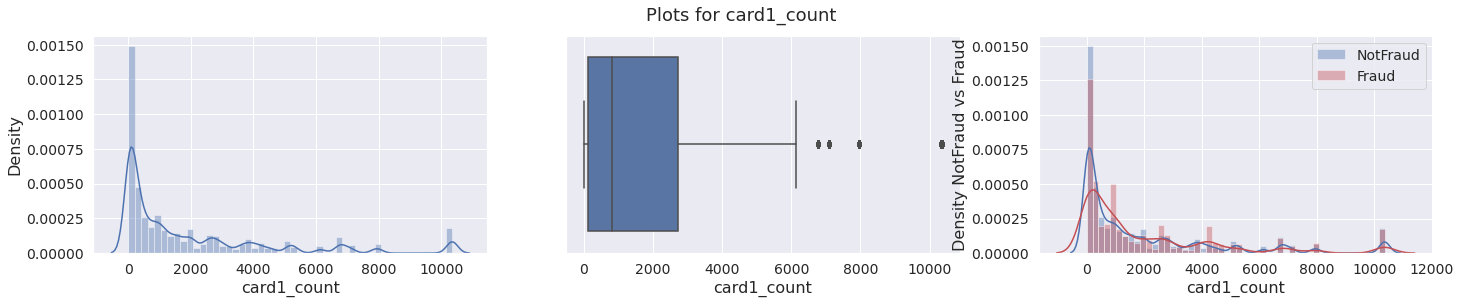

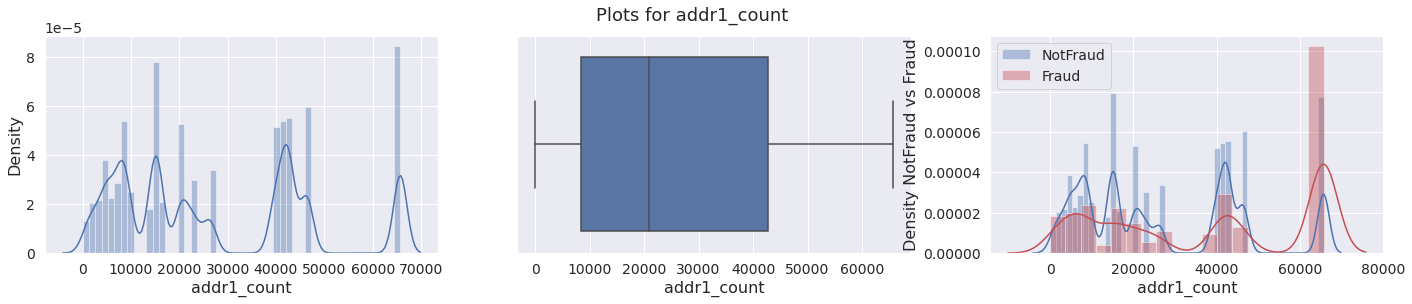

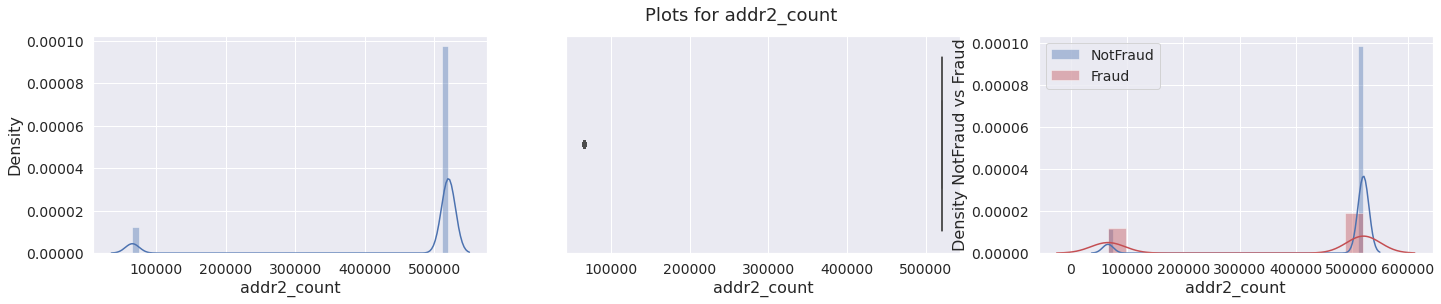

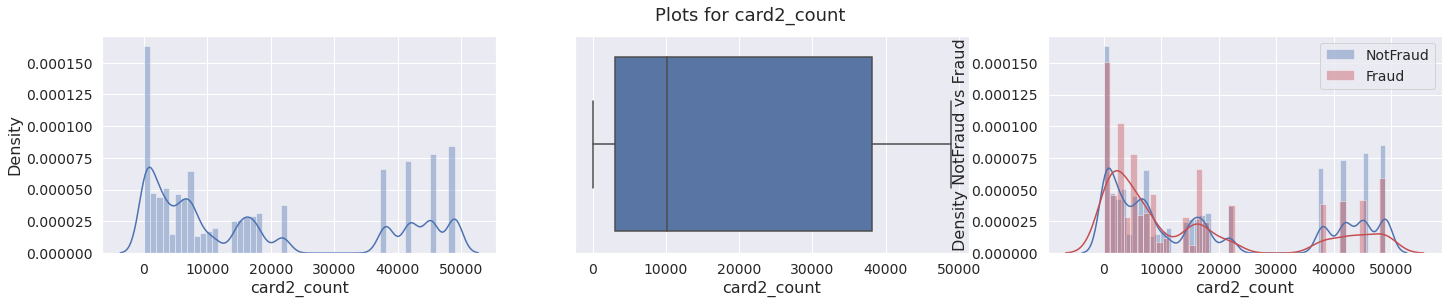

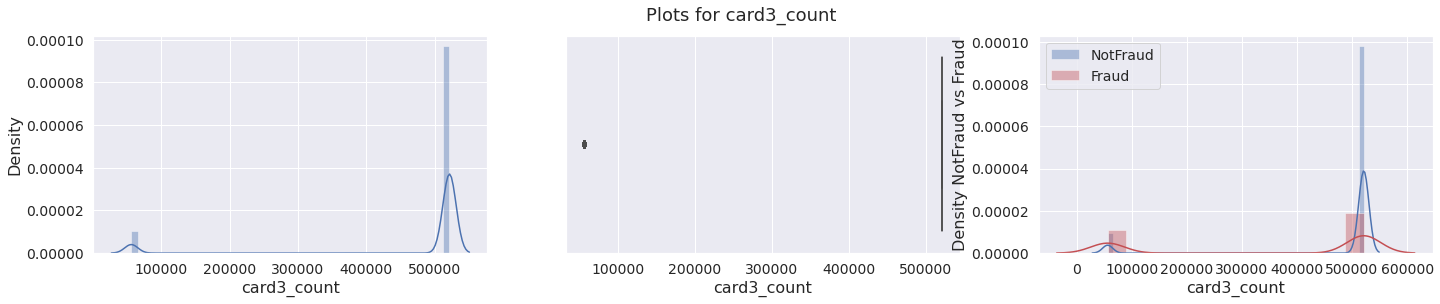

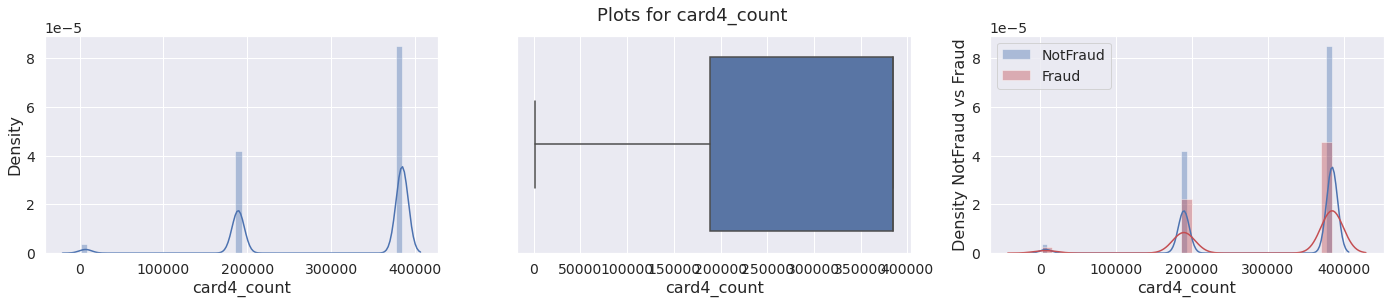

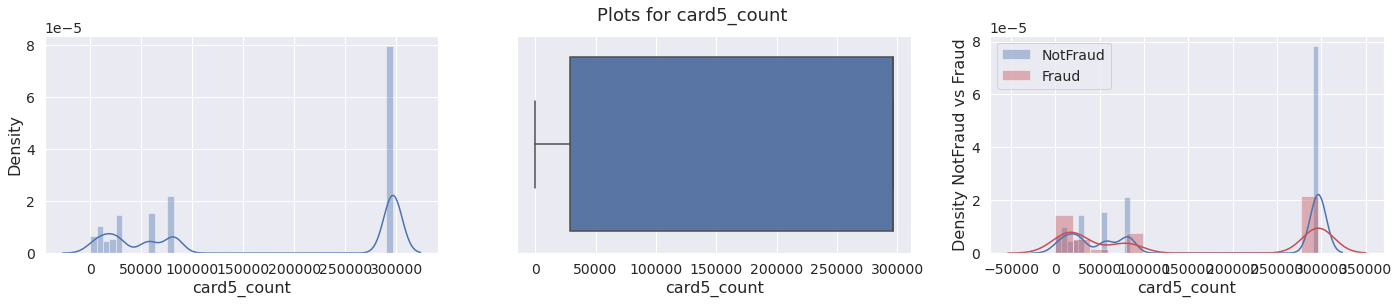

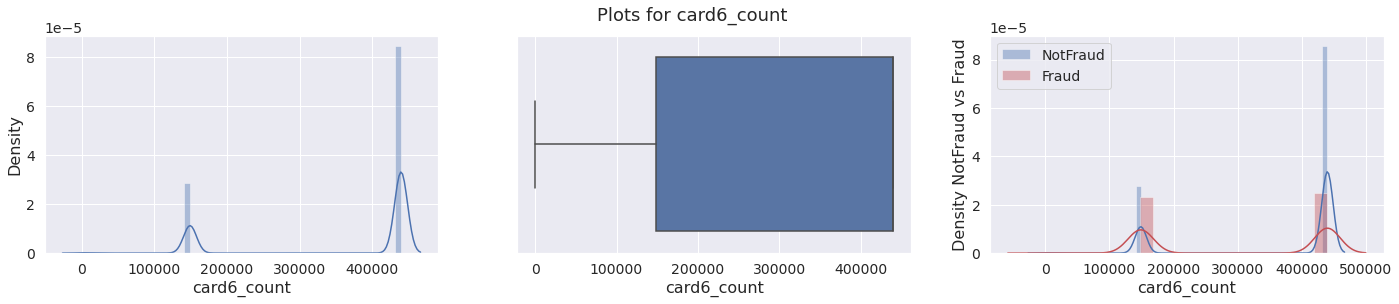

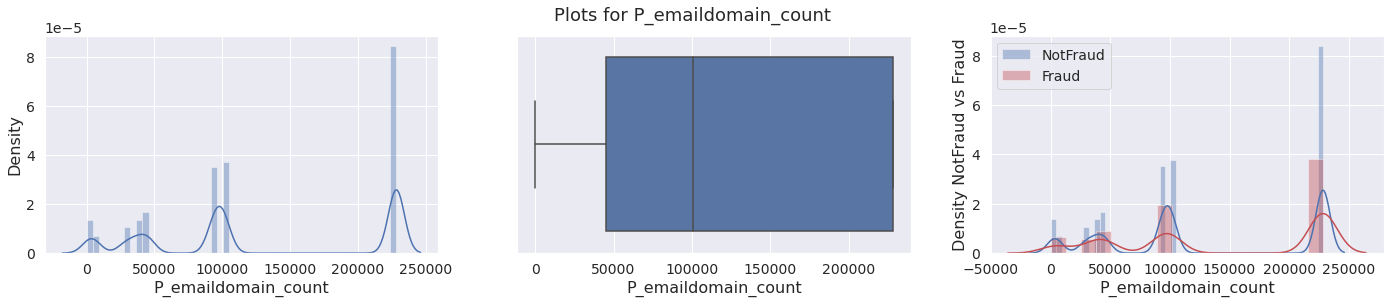

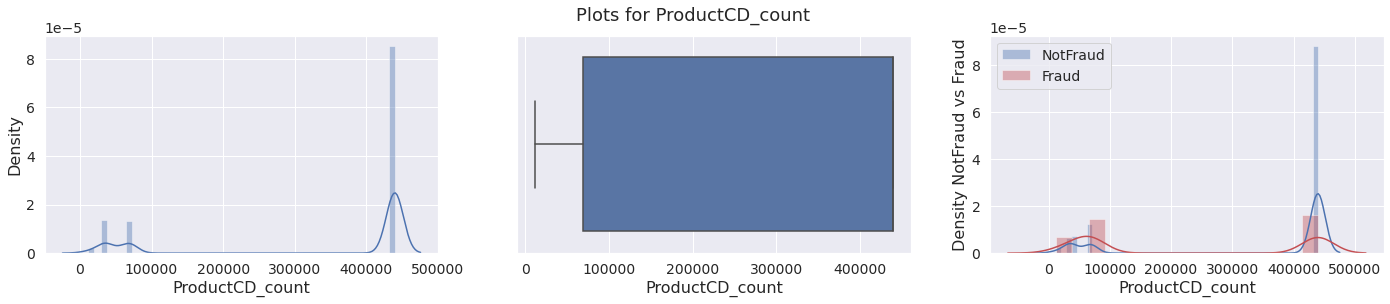

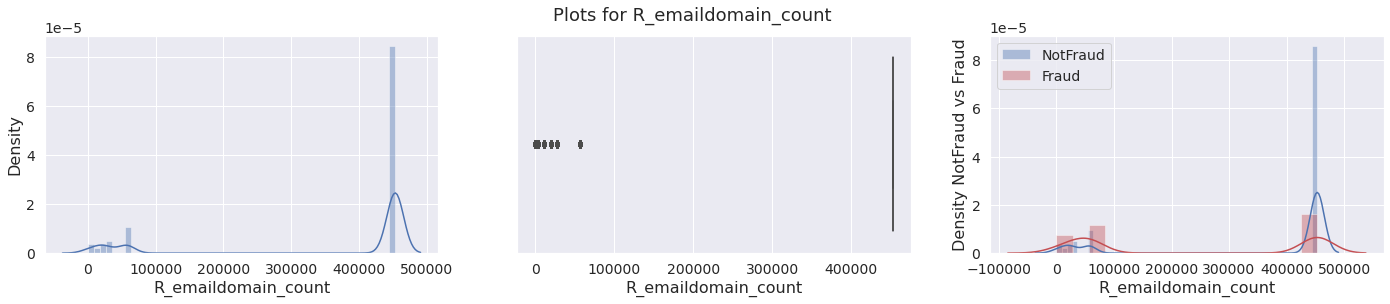

In [19]:
freq_cols = ['card1', 'addr1', 'addr2', 'card2', 'card3', 'card4', 'card5',
             'card6', 'P_emaildomain', 'ProductCD', 'R_emaildomain']
for col in freq_cols:
    display_features.append(col)
    
    train[col + '_count'] = train[col].map(train[col].value_counts(dropna=False) )
    test[col + '_count'] =  test[col].map(train[col].value_counts(dropna=False) )
    display_features.append(col + '_count')
    plot_numeric_data(train, col + '_count',  TARGET, remove_outliers = True)

### New Feature: Hour of the day
* From TransactionDT extract the hour of day of the transaction time, encoded as 0-23
* TransactionDT field indicates the timestamp of a transaction and we can extract time related data from it
* We can see that more frauds are committed between 1AM and 11 AM. This is probably because fraud originated in different time zone


In [20]:
def make_hour_feature(df, tname='TransactionDT'):
    #Creates an hour of the day feature, encoded as 0-23.  
   
    hours = df[tname] / (3600)        
    encoded_hours = np.floor(hours) % 24
    return encoded_hours

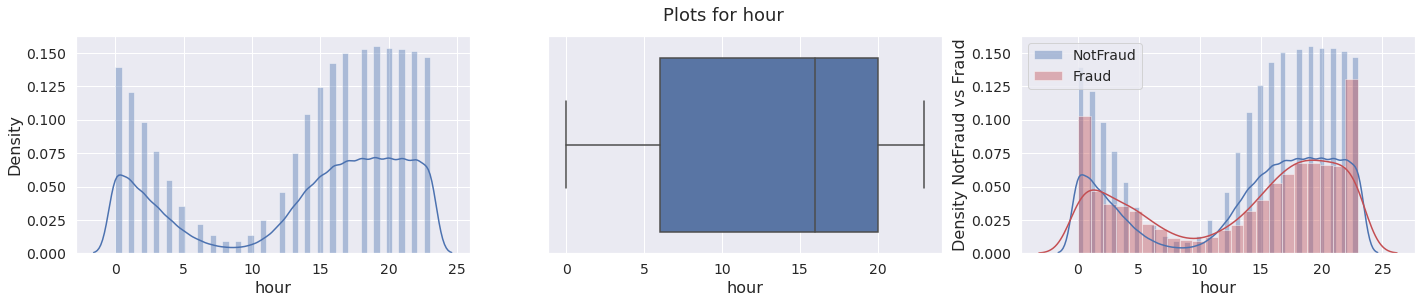

In [21]:
display_features.append('TransactionDT')

col = 'hour'
train[col] = make_hour_feature(train)
test[col] = make_hour_feature(test)
display_features.append(col)

plot_numeric_data(train, col,  TARGET, remove_outliers = True)

## Display Fraud Transactions for New Features 
Display data with new features and source features for which transactions were fraud


In [22]:
display_features.append(TARGET)
train[train[TARGET]==1][display_features].head(10)

,TransactionID,nulls,TransactionAmt,TAmt_decimal,card1,card1_count,addr1,addr1_count,addr2,addr2_count,card2,card2_count,card3,card3_count,card4,card4_count,card5,card5_count,card6,card6_count,P_emaildomain,P_emaildomain_count,ProductCD,ProductCD_count,R_emaildomain,R_emaildomain_count,TransactionDT,hour,isFraud
203,2987203,228,445.000,0,18268,1130,251.0,5216,87.0,520481,583.0,21803,150.0,521287,visa,384767,226.0,296546,credit,148986,aol.com,28289,W,439670,NaN,453249,89760,0.0,1
240,2987240,113,37.098,97,13413,349,NaN,65706,NaN,65706,103.0,3468,185.0,56346,visa,384767,137.0,11720,credit,148986,hotmail.com,45250,C,68519,hotmail.com,27509,90193,1.0,1
243,2987243,88,37.098,97,13413,349,NaN,65706,NaN,65706,103.0,3468,185.0,56346,visa,384767,137.0,11720,credit,148986,hotmail.com,45250,C,68519,hotmail.com,27509,90246,1.0,1
245,2987245,88,37.098,97,13413,349,NaN,65706,NaN,65706,103.0,3468,185.0,56346,visa,384767,137.0,11720,credit,148986,hotmail.com,45250,C,68519,hotmail.com,27509,90295,1.0,1
288,2987288,98,155.521,521,16578,60,NaN,65706,NaN,65706,545.0,16355,185.0,56346,visa,384767,226.0,296546,credit,148986,outlook.com,5096,C,68519,outlook.com,2507,90986,1.0,1
367,2987367,127,225.000,0,4425,307,472.0,8478,87.0,520481,562.0,3756,150.0,521287,mastercard,189217,197.0,1551,credit,148986,gmail.com,228355,R,37699,gmail.com,57147,92350,1.0,1
405,2987405,99,90.570,569,4504,974,NaN,65706,NaN,65706,500.0,5045,185.0,56346,mastercard,189217,219.0,9924,credit,148986,gmail.com,228355,C,68519,gmail.com,57147,92999,1.0,1
630,2987630,92,12.326,325,5812,2818,NaN,65706,NaN,65706,408.0,8012,185.0,56346,mastercard,189217,224.0,81513,debit,439938,gmail.com,228355,C,68519,gmail.com,57147,97843,3.0,1
683,2987683,87,124.344,343,5812,2818,NaN,65706,NaN,65706,408.0,8012,185.0,56346,mastercard,189217,224.0,81513,debit,439938,gmail.com,228355,C,68519,gmail.com,57147,99584,3.0,1
736,2987736,228,100.000,0,15063,2522,231.0,7605,87.0,520481,NaN,8933,150.0,521287,visa,384767,226.0,296546,credit,148986,yahoo.com,100934,W,439670,NaN,453249,100591,3.0,1


## Data Pre-Processing
* Concatenate the training and test dataset by appending. This is done so that we can apply feature engineering and pre-processing steps to combined set.
* Convert the categorical features from string to int using ordinal encoding. For example, convert ['A', 'B'. 'C'] to [1,2,3]
* Create a data frame sub for submission of test scores, we will later fill it with predictions on test set


In [23]:



# Concatenate the tranining and test dataset by appending
data_all = train.append(test, ignore_index = True, sort=False)

#Create submission pandas dataframe 
sub = pd.DataFrame()
sub['TransactionID'] = test.TransactionID



# free the memory which is not required as it can exceed the physical ram 
del train, test
gc.collect()


15492

In [24]:



# Do ordinal encoding for categorical features
for col in cat_cols:
    data_all[col], uniques = pd.factorize(data_all[col])
    #the factorize sets null values to -1, so convert them back to null, as we want LGB to handle null values
    data_all[col] = data_all[col].replace(-1, np.nan)
    

    


## Create Test, Train and Validation sets
* From combined dataset split the training and test datasets and separate the target and features
* Split the training set into training and validation set. We will use first 80% of data as training set and last 20% as validation set.
* Since the data is sorted in time according to transaction timestamp, we should not use random split.


In [25]:
from sklearn.model_selection import train_test_split

#For test set target value will be null
X_train =  data_all[data_all[TARGET].notnull()]
X_test  =  data_all[data_all[TARGET].isnull()]
del data_all
gc.collect()

#get the labels for traning set
y_train = X_train[TARGET]

# Remove ID and TARGET column from train and test set
X_train = X_train.drop(['TransactionID', TARGET], axis = 1)
X_test = X_test.drop(['TransactionID',   TARGET], axis = 1)

# Split the training set into training and validation set. 
# We will use first 80% of data as traningg set and last 20% as validation set.
# Since the data is sorted in time according to transaction timestamp, we should not use random split.
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, shuffle=False, 
                                                      random_state = RANDOM_STATE)

print('Train shape{} Valid Shape{}, Test Shape {}'.format(X_train.shape, X_valid.shape, X_test.shape))

Train shape(472432, 446) Valid Shape(118108, 446), Test Shape (506691, 446)


## Train LightGBM Model With Validation
* LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient https://lightgbm.readthedocs.io/en/latest/Features.html
* In this notebook we are using LightGBM in random forest mode, which trains on parallel trees. This is done by setting parameter boosting_type = 'random_forest'.
* Train on first 80% of dataset and evaluate on next 20 % as data is sorted in time
* parameter 'SCALE_POS_WEIGHT' is to handle the unbalanced nature of dataset. This parameter gives more weight to minority class, which improves precision, recall and F1 scores
* No imputation of missing values is necessary as LightGBM can use optimized strategies automatically.
* New Features created in above section will be also be used if they are in Top N features list


In [26]:
from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score,confusion_matrix

def validation_results(y_valid, y_prob, verbose = True):   
    scores = {}                      
    y_pred_class =  [0  if x < 0.5 else 1 for x in y_prob]
    scores['val_accuracy']  = accuracy_score(y_valid, y_pred_class)
    scores['val_auc']       = roc_auc_score(y_valid, y_prob)
    scores['val_f1']        =   f1_score(y_valid, y_pred_class, average = 'binary')
    scores['val_precision'] = precision_score(y_valid, y_pred_class)
    scores['val_recall']    = recall_score(y_valid, y_pred_class)
    
    cm = confusion_matrix(y_valid, y_pred_class)
    cm_df = pd.DataFrame(cm, columns=np.unique(y_valid), index = np.unique(y_valid))
    if verbose:
        print('\nValidation Accuracy      {:0.5f}'.format( scores['val_accuracy'] ))
        print('Validation   AUC         {:0.5f}'.format( scores['val_auc']   ))
        print('Validation Precision     {:0.5f}'.format(scores['val_precision']))
        print('Validation Recall        {:0.5f}'.format(scores['val_recall']))
        print('Validation  F1           %0.5f' %scores['val_f1'] )
    return scores , cm_df




In [27]:
%%time

import lightgbm as lgb

feature_imp = pd.DataFrame()

params = {}

params['learning_rate'] = 0.06
params['boosting_type'] = 'random_forest'
params['objective'] = 'binary'
params['seed'] =  RANDOM_STATE
params['metric'] =    'auc'
params['bagging_fraction'] = 0.7
params['bagging_freq'] = 5
params['feature_fraction'] = 0.7
# params['max_bin'] = 127
params['scale_pos_weight'] = 2
params['num_leaves'] = 256



print('Train shape{} Valid Shape{}, Test Shape {}\n'.format(X_train.shape, X_valid.shape, X_test.shape))

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid  = lgb.Dataset(X_valid, y_valid)
early_stopping_rounds = 200
lgb_results = {}

model = lgb.train(params,
                      lgb_train,
                      num_boost_round = 10000,
                      valid_sets =  [lgb_train,lgb_valid],
                      early_stopping_rounds = early_stopping_rounds,                    
    #                   categorical_feature = cat_cols,
                      evals_result = lgb_results,
                      verbose_eval = 100
                       )

print('\nPrinting Model Parameters\n')
print(params)

Train shape(472432, 446) Valid Shape(118108, 446), Test Shape (506691, 446)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.89935	valid_1's auc: 0.866179
[200]	training's auc: 0.89949	valid_1's auc: 0.866842
[300]	training's auc: 0.899694	valid_1's auc: 0.867207
[400]	training's auc: 0.899624	valid_1's auc: 0.867424
[500]	training's auc: 0.900043	valid_1's auc: 0.867846
[600]	training's auc: 0.900009	valid_1's auc: 0.867864
[700]	training's auc: 0.900194	valid_1's auc: 0.867834
Early stopping, best iteration is:
[535]	training's auc: 0.900198	valid_1's auc: 0.867972

Printing Model Parameters

{'learning_rate': 0.06, 'boosting_type': 'random_forest', 'objective': 'binary', 'seed': 42, 'metric': 'auc', 'bagging_fraction': 0.7, 'bagging_freq': 5, 'feature_fraction': 0.7, 'scale_pos_weight': 2, 'num_leaves': 256}
CPU times: user 33min 11s, sys: 15.4 s, total: 33min 27s
Wall time: 8min 47s


## Display Results

In [28]:
y_prob = model.predict(X_valid)
results, cm_df  = validation_results(y_valid, y_prob, verbose = True)



Validation Accuracy      0.92853
Validation   AUC         0.86797
Validation Precision     0.25937
Validation Recall        0.58046
Validation  F1           0.35854


### Display Confusion Matrix

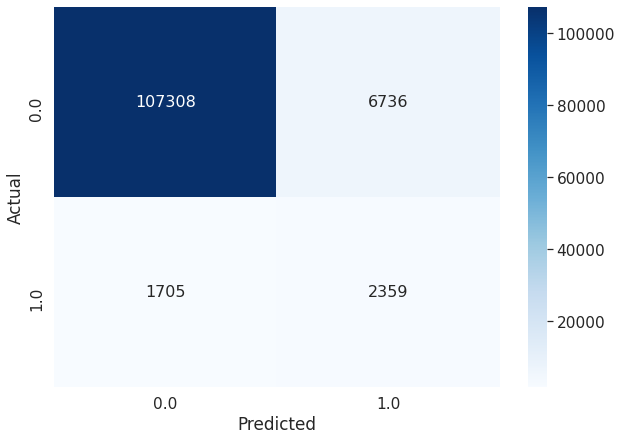

In [29]:

cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm_df, cmap="Blues", annot=True,annot_kws={"size": 16}, fmt='g')# font size
plt.show()

### Plot Training vs Validation scores

In [30]:

def plot_lgb_scores(lgb_results):
    train_res = lgb_results['training']['auc']
    valid_res = lgb_results['valid_1']['auc']
    ntrees = range(1, len(train_res) + 1)

    plt.figure(figsize = (12, 6))
    plt.plot(ntrees, train_res , 'b', label = 'Training')
    plt.plot(ntrees, valid_res, 'r', label = 'Validation')
    plt.xlabel('Number of Trees', fontsize = 14)
    plt.ylabel('AUC Score', fontsize = 14)
    plt.legend(fontsize = 14)
    plt.show()
    

    


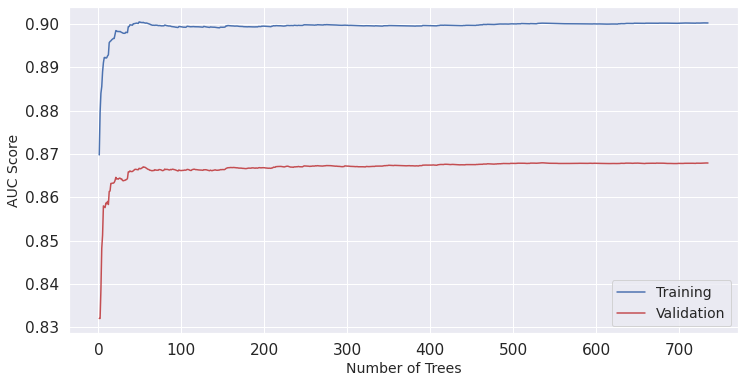

In [31]:
plot_lgb_scores(lgb_results)

### Plot ROC Curve

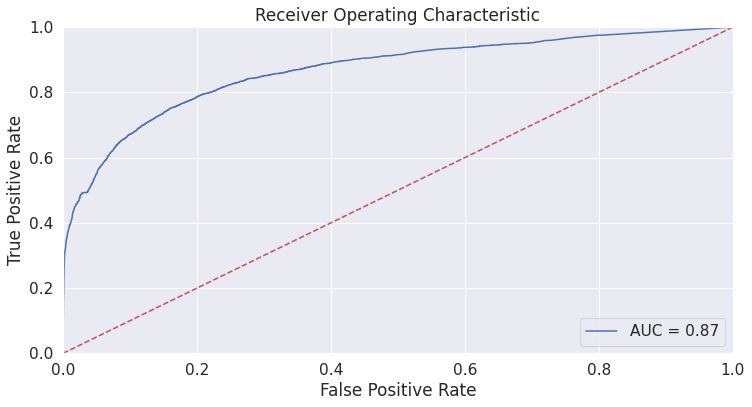

In [32]:



import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_prob)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize = (12, 6))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Plot Feature Importance
Display top 20 features 

In [33]:
def plot_feature_imp(model, top_n = 30):
    feature_imp = pd.DataFrame()
    feature_imp['feature'] = model.feature_name()
    feature_imp['importance']  = model.feature_importance()
    feature_imp = feature_imp.sort_values(['importance'], ascending = False)
    feature_imp_disp = feature_imp.head(top_n)
    plt.figure(figsize=(10, 12))
    sns.barplot(x="importance", y="feature", data=feature_imp_disp)
    plt.title('LightGBM Features')
    plt.show() 
#     return feature_imp

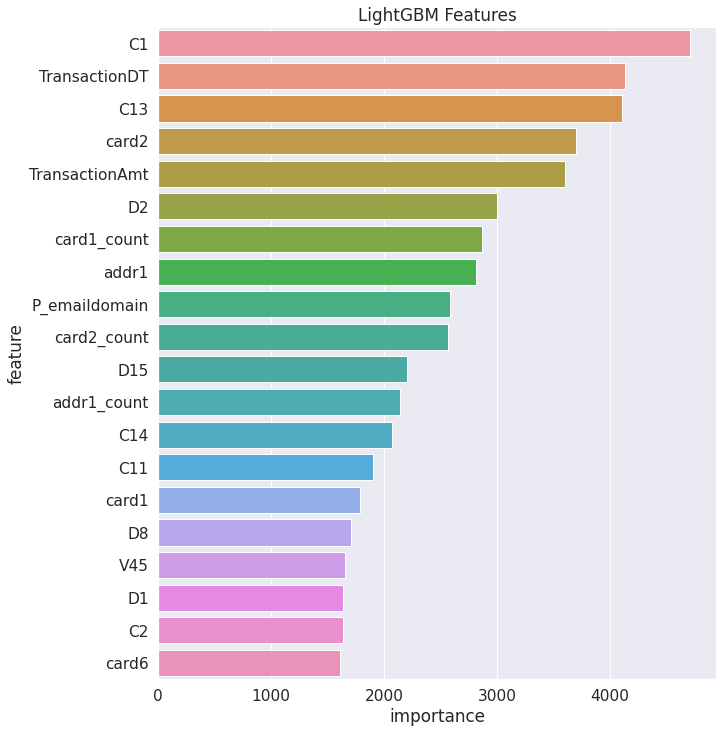

In [34]:
plot_feature_imp(model, top_n = 20)

## Predict on test set
Also write the results as csv file

In [35]:
y_prob_test = model.predict(X_test)
sub['isFraud'] = y_prob_test
sub.to_csv('lgb_sub.csv', index=False)
sub.head()

,TransactionID,isFraud
0,3663549,0.021819
1,3663550,0.025120
2,3663551,0.030305
3,3663552,0.018103
4,3663553,0.019036


## Summary

* Do basic data preprocessing steps to convert categorical variables to integers using ordinal encoding.
* Train on a LightGBM model with 80% data and 20% validation date. We are using Random Forest mode by setting parameter boosting_type = 'random_forest'
* Use metric AUC to evaluate the performance of model.
* Handle Imbalanced Dataset by using inbuilt model parameter SCALE_POS_WEIGHT= 4. Using this we were able to improve F1 Score from 0.38244(Baseline Model) to  0.56081 on current model
* The Validation AUC score for Random Forest is 0.867972 while AUC on public test data is 0.891612. The random Forest performs worse than LightGBM and XGBOOST where we were able to score AUC 0.918617 for XGBoost and 0.923118 for LightGBM on public test data
